In [1]:
import pandas as pd
import csv 
import geopandas as gpd
from datetime import timedelta
from shapely.geometry import Point
import glob
from shapely import wkt

/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [8]:
#read csv files and adjust to datetime

#imagery dates
R_im_date = pd.read_csv('../data/Ramsey/RamseyImageryDates.csv', parse_dates=['date'])
R_im_date['date'] = pd.to_datetime(R_im_date['date'])

#survey dates
R_sur_date = pd.read_csv('../data/Ramsey/RamseySurveyDates.csv', delimiter=';', index_col=False, parse_dates = ['Ramsey wet/dry date']) 
R_sur_date.rename(columns={'Ramsey wet/dry date':'date'}, inplace=True )
R_sur_date['date'] = pd.to_datetime(R_sur_date['date'], format = '%m/%d/%Y', errors = 'coerce')
R_sur_date = R_sur_date.dropna(subset = ['date'])

#hydrological data (precipitation and streamflow)
R_hyd = pd.read_csv('../data/Ramsey/RamseyHydroData.csv')
R_hyd.rename( columns={'Unnamed: 0':'date'}, inplace=True )
R_hyd['date'] = pd.to_datetime(R_hyd['date'])

#new precipitation file used later
R_precipitation = pd.read_csv('../data/Ramsey/daymet_precip.csv')
R_precipitation['system:time_start'] = pd.to_datetime(R_precipitation['system:time_start'])
R_precipitation.rename( columns={'00000000000000000000':'P','system:time_start':'day'}, inplace=True )

# #surveydata with geometries having a wet/dry label, dates are only given in year
# R_surveyData = pd.read_csv('../data/Ramsey/Ramsey_surveyData.csv')

R_sur_date = pd.concat([R_sur_date,pd.DataFrame.from_dict({'Unnamed: 0':[2024_1],
                                                           'date':[pd.to_datetime('2024-09-19')]})])


In [9]:
# R_surveyData

In [10]:
#find matching dates between survey and imagery
matching_dates = []
tolerance = timedelta(days = 5)

for date1 in R_sur_date['date']:
    exact_date = False
    tol = False 
    for date2 in R_im_date['date']:
        if date1 == date2:
            matching_dates.append({'Survey': date1, 'Imagery': date2})
            exact_date = True
    if not exact_date:
        for date2 in R_im_date['date']:
            if abs(date1 - date2) <= tolerance:
                matching_dates.append({'Survey': date1, 'Imagery': date2})
                tol = True
        if not tol: 
            for date2 in R_im_date['date']:
                if abs(date1-date2) < timedelta(days = 10): 
                    matching_dates.append({'Survey': date1, 'Imagery': date2})


matching_df = pd.DataFrame(matching_dates)


In [11]:
R_datessurData = pd.merge(matching_df, R_hyd, left_on = 'Survey', right_on = 'date', how = 'left')
R_datesimData = pd.merge(matching_df, R_hyd, left_on = 'Imagery', right_on = 'date')
#R_datessurData = R_datessurData.drop(columns = ['Imagery','date'])
#R_datesimData = R_datesimData.drop(columns = ['Survey','date'])


In [12]:
#sum precipitation for dates in between survey and imagery
def sum_pdatesbetween(d1, d2):
    r = pd.date_range(start=min(d1,d2), end=max(d1,d2))
    return R_hyd[R_hyd['date'].isin(r)]['P [mm]'].sum()

In [13]:
#making a dataframe to determine which imagery dates to use
Rh = pd.DataFrame([])

Rh['Survey'] = matching_df['Survey']
Rh['Imagery'] = matching_df['Imagery']
Rh['sum_P'] = [sum_pdatesbetween(R_datessurData.loc[i, 'Survey'], R_datesimData.loc[i, 'Imagery']) for i in range(len(Rh))]
Rh['Q_s-i'] = (R_datessurData['Q [mm/d]'] - R_datesimData['Q [mm/d]']) / R_datessurData['Q [mm/d]'] * 100
Rh['Use/not'] = ['use', 'use', 'use', 'use', 'not', 'not',
                 'not', 'use', 'not', 'use'] 

Rh = Rh.fillna('')

conditions = (Rh['Use/not'] == 'not')

Rh = Rh[~conditions]

Rh = Rh.drop(columns=['Use/not'])

Rh

,Survey,Imagery,sum_P,Q_s-i
0,2018-06-23,2018-06-23,0.000000,
1,2019-06-15,2019-06-15,0.000000,0.0
2,2020-06-15,2020-06-15,0.931333,0.0
3,2021-06-16,2021-06-16,0.000000,
7,2022-06-12,2022-06-13,0.000000,
9,2023-06-13,2023-06-13,0.000000,0.0


In [46]:
Rh.to_csv('../data/Ramsey/Ramsey_survey_imagery_hydro.csv', index = 'False')

In [47]:
#First adjusting the dates in surveyData, as they are only logged with the respective year and not exact date
R_sur_date['Year'] = R_sur_date['date'].dt.year
R_surveyData['Year'] = R_surveyData['Year'].astype(int)
Rdata = pd.merge(R_surveyData, R_sur_date[['date', 'Year']], on = 'Year', how = 'left')
Rdata = Rdata.drop(columns=['Year', 'Unnamed: 0'])
Rdata.rename(columns = {'date':'Year'}, inplace = True)
Rdata = Rdata.drop_duplicates()
Rdata

,geometry,wetdry,Year
0,POINT (565823.6275333037 3479456.4153816323),dry,2020-06-15
1,POINT (565819.4561564658 3479453.6586416597),dry,2020-06-15
2,POINT (565815.2847796278 3479450.9019016875),dry,2020-06-15
3,POINT (565811.1134027899 3479448.145161715),dry,2020-06-15
4,POINT (565806.9420259519 3479445.3884217422),dry,2020-06-15
...,...,...,...
11746,POINT (562874.0836776034 3477329.7796896184),dry,2023-06-13
11747,POINT (562869.7411883774 3477332.2250877917),dry,2023-06-13
11748,POINT (562865.6273257725 3477335.066941846),dry,2023-06-13
11749,POINT (562861.5134631676 3477337.908795901),dry,2023-06-13


In [48]:
#survey data with dates into a geodataframe and adding x and y from the geometry to 
#facilitate merge

Rdata['geometry'] = Rdata['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(Rdata, geometry = 'geometry')#, crs='EPSG:26912')

gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
gdf = gdf[['geometry', 'x', 'y', 'wetdry', 'Year']]
#gdf['Year'] = gdf['Year'].astype(int) 
#gdf['Year'] = pd.to_datetime(gdf['Year'])
gdf

,geometry,x,y,wetdry,Year
0,POINT (565823.628 3479456.415),565823.627533,3.479456e+06,dry,2020-06-15
1,POINT (565819.456 3479453.659),565819.456156,3.479454e+06,dry,2020-06-15
2,POINT (565815.285 3479450.902),565815.284780,3.479451e+06,dry,2020-06-15
3,POINT (565811.113 3479448.145),565811.113403,3.479448e+06,dry,2020-06-15
4,POINT (565806.942 3479445.388),565806.942026,3.479445e+06,dry,2020-06-15
...,...,...,...,...,...
11746,POINT (562874.084 3477329.78),562874.083678,3.477330e+06,dry,2023-06-13
11747,POINT (562869.741 3477332.225),562869.741188,3.477332e+06,dry,2023-06-13
11748,POINT (562865.627 3477335.067),562865.627326,3.477335e+06,dry,2023-06-13
11749,POINT (562861.513 3477337.909),562861.513463,3.477338e+06,dry,2023-06-13


In [49]:
#Checking for perennial reaches by comparing surveys of each year

gdf = gdf.set_geometry('geometry')#, crs='EPSG:26912')
#gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
#gdf['geometry_wkt'] = gdf['geometry'].apply(lambda geom: geom.wkt)

perennial = pd.DataFrame(gdf.groupby('geometry')['wetdry'].apply(lambda x: sum(x == 'wet'))).reset_index(drop=False)

# whichever number is reasonable based on data?
perennial = perennial[(perennial['wetdry'] == 6)]

#assume always wet
perennial = perennial.assign(wetdry = 'wet')
#perennial['geometry'] = perennial['geometry_wkt'].apply(wkt.loads)
#perennial = perennial.drop(columns=['geometry_wkt'])

#perennial['geometry'] = perennial['geometry'].apply(wkt.loads)
gdf_perennial = gpd.GeoDataFrame(perennial, geometry = 'geometry')#, crs='EPSG:26912')
gdf_perennial['x'] = gdf_perennial.geometry.x
gdf_perennial['y'] = gdf_perennial.geometry.y

#making the gdf matching the perennial reaches to the imagery dates available 
imagery_perennial = pd.concat([gdf_perennial.assign(imagery = date) for date in R_im_date['date']], ignore_index=True)
imagery_perennial = imagery_perennial[~imagery_perennial['imagery'].isin(Rh['Imagery'])]
imagery_perennial['assumption'] = len(imagery_perennial)*['assumed perennial']
imagery_perennial

,geometry,wetdry,x,y,imagery,assumption
0,POINT (563355.942 3476901.683),wet,563355.942397,3.476902e+06,2016-07-22,assumed perennial
1,POINT (563360.942 3476901.713),wet,563360.942305,3.476902e+06,2016-07-22,assumed perennial
2,POINT (563355.942 3476901.683),wet,563355.942397,3.476902e+06,2016-08-28,assumed perennial
3,POINT (563360.942 3476901.713),wet,563360.942305,3.476902e+06,2016-08-28,assumed perennial
4,POINT (563355.942 3476901.683),wet,563355.942397,3.476902e+06,2016-09-17,assumed perennial
...,...,...,...,...,...,...
2315,POINT (563360.942 3476901.713),wet,563360.942305,3.476902e+06,2024-03-22,assumed perennial
2316,POINT (563355.942 3476901.683),wet,563355.942397,3.476902e+06,2024-03-27,assumed perennial
2317,POINT (563360.942 3476901.713),wet,563360.942305,3.476902e+06,2024-03-27,assumed perennial
2318,POINT (563355.942 3476901.683),wet,563355.942397,3.476902e+06,2024-03-28,assumed perennial


<Axes: >

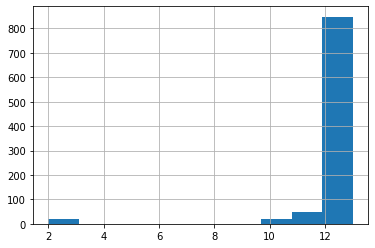

In [50]:
gdf.groupby('geometry').count().wetdry.hist()

In [51]:
# merging to be able to use the new precipitation data
R_new_hyd = R_hyd.merge( R_precipitation, left_on = 'date', right_on = 'day')
R_new_hyd = R_new_hyd.drop(columns = ['day', 'P [mm]'])
R_new_hyd.rename( columns={'P':'P [mm]'}, inplace=True )
R_new_hyd.set_index(['date'], drop =True, inplace = True)
R_new_hyd

,Q [mm/d],P [mm]
date,,
2016-01-01,0.000481,0.00
2016-01-02,0.000481,0.00
2016-01-03,0.000481,0.00
2016-01-04,0.000682,16.30
2016-01-05,0.000662,4.45
...,...,...
2023-12-27,0.000000,0.00
2023-12-28,0.000000,0.00
2023-12-29,0.000000,0.00


In [52]:
#function to define assumptions around dates to choose, based on streamflow and precipitation
def tolerance(Q_P_data, date, start, adjust, tolerance_p, P_condition = -999, Q_condition = -999):
    
    sub_grupp = Q_P_data.copy()
    
    if adjust == 'start':      
        sub_grupp = Q_P_data.loc[start:].copy()       
        
    elif adjust == 'end': #reverse index to loop backwards
        sub_grupp = sub_grupp.loc[:start].copy().iloc[::-1]        
    
    else:
        print('Invalid adjust parameter. Please use "start" or "end"')
        return

    
    # Reset index if reversed
    sub_grupp.reset_index(inplace=True)
     
    sub_grupp['Q_diff'] = sub_grupp['Q [mm/d]'].diff().fillna(0)

    if adjust == 'start':
        sub_grupp['tolerance_condition'] = (sub_grupp.Q_diff < tolerance_p * sub_grupp['Q [mm/d]'])

    if adjust == 'end':
        sub_grupp['tolerance_condition'] = (sub_grupp.Q_diff > -tolerance_p * sub_grupp['Q [mm/d]'])
    
    if P_condition == -999 == Q_condition:
        print('not a valid condition')
        return 
        
    elif P_condition == -999:
        if Q_condition > 0:
            sub_grupp['condition'] = sub_grupp['Q [mm/d]'] > Q_condition
        else:
            sub_grupp['condition'] = sub_grupp['Q [mm/d]'] < -Q_condition
            
    elif Q_condition == -999:
        if P_condition > 0:
            sub_grupp['condition'] = sub_grupp['P [mm]'] > P_condition
        else:
            sub_grupp['condition'] = sub_grupp['P [mm]'] < -P_condition
            
    else:
        if (Q_condition > 0) & (P_condition > 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] > Q_condition) & (sub_grupp['P [mm]'] > P_condition)
        elif (Q_condition < 0) & (P_condition > 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] < -Q_condition) & (sub_grupp['P [mm]'] > P_condition)           
        elif (Q_condition > 0) & (P_condition < 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] > Q_condition) & (sub_grupp['P [mm]'] < -P_condition)            
        else:
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] < -Q_condition) & (sub_grupp['P [mm]'] < -P_condition)

    #where conditions are met
    yesgroup = sub_grupp[(sub_grupp['condition'] == True) & (sub_grupp['tolerance_condition'] == True)] 
       
  
    if len(yesgroup) == 0:
        print('No data where conditions are met')
        return pd.DataFrame()
        
    #where conditions are not met
    nogroup = sub_grupp[(sub_grupp['condition'] == False) | (sub_grupp['tolerance_condition'] == False)]  
    
    if len(nogroup) == 0:
        print('nogroup = 0')
        return sub_grupp.loc[yesgroup.index[0]:]

    if yesgroup.index[0] < nogroup.index[0]:
        print('everything is fine')
        return sub_grupp.loc[:nogroup.index[0]]
    
    else:
        print('No valid range found between yesgroup and nogroup indices')
        return pd.DataFrame()




In [53]:
#assumption of dry dates after the survey date while in a recession 


dry_list = []

for date in Rdata['Year'].unique():
    dry1 = tolerance(R_new_hyd, 'date', date, 'start', 0.05, Q_condition = -999, P_condition = -1)
    if len(dry1) == 0:
        print('dry1 is empty')
        continue
    dry1 = dry1[~dry1['date'].isin(Rh['Imagery'])]
    dry_imagery = pd.merge(dry1, R_im_date, on = ['date'], how = 'inner')
    #print(len(dry_imagery))
    dry_points = pd.DataFrame(gdf[gdf['Year']== (date)] .groupby('geometry')['wetdry'].apply(lambda x: (x == 'dry'))).reset_index(drop = False)
    dry_points = dry_points.assign(wetdry = 'dry')
    dry_im_points = [dry_points.assign(imagery = date) for date in dry_imagery['date']]
    #print(len(dry_im_points))
    
    try:
        dry = pd.concat(dry_im_points).drop(columns = ['level_1'])
        dry_list.append(dry)
    except:
        if len(dry_im_points)==0:
            print('No data for date '+ date.strftime('%Y-%m-%d'))
        else:
            dry = dry_im_points[0]
            dry_list.append(dry)
    #print(len(dry))
    

dry_df = pd.concat(dry_list)
dry_df['assumption'] = len(dry_df)*['assumed dry']




No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2016-06-21
everything is fine
No data for date 2014-06-19
everything is fine
No data for date 2009-06-15
No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2012-06-13
everything is fine
No data for date 2015-06-15
No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2013-06-11
No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2010-06-10
everything is fine
everything is fine


In [54]:
#assuming wet stretches for the dates before
#assumption is made with 5 % difference in streamflow and for dates before survey when in a recession 

wet_list = []

for date in Rdata['Year'].unique():
            
    wet1 = tolerance(R_new_hyd, 'date', date, 'end', 0.05, Q_condition = -999, P_condition = -1)
    if len(wet1) == 0:
        print('wet1 is empty')
        continue
    wet1 = wet1[~wet1['date'].isin(Rh['Imagery'])]
    wet_imagery = pd.merge(wet1, R_im_date, on = ['date'], how = 'inner')
    #print(len(wet_imagery))
    wet_points = pd.DataFrame(gdf[gdf['Year']== (date)].groupby('geometry')['wetdry'].apply(lambda x: sum(x == 'wet'))).reset_index(drop = False)
    wet_points = wet_points[~wet_points['geometry'].isin(perennial['geometry'])]
    wet_points = wet_points[(wet_points['wetdry'] == 1)]
    wet_points = wet_points.assign(wetdry = 'wet')
    wet_im_points = [wet_points.assign(imagery = date) for date in wet_imagery['date']]
        
    try:
        wet = pd.concat(wet_im_points).drop(columns = ['level_1'])
        wet_list.append(wet)
    except:
        if len(wet_im_points)==0:
            print('No data for date '+ date.strftime('%Y-%m-%d'))
        else:
            wet = wet_im_points[0]
            wet_list.append(wet)
        

wet_df = pd.concat(wet_list)


wet_df['assumption'] = len(wet_df)*['assumed wet']

No valid range found between yesgroup and nogroup indices
wet1 is empty
everything is fine
No data for date 2016-06-21
No data where conditions are met
wet1 is empty
No data where conditions are met
wet1 is empty
No valid range found between yesgroup and nogroup indices
wet1 is empty
No data where conditions are met
wet1 is empty
No data where conditions are met
wet1 is empty
No valid range found between yesgroup and nogroup indices
wet1 is empty
No data where conditions are met
wet1 is empty
No valid range found between yesgroup and nogroup indices
wet1 is empty
No data where conditions are met
wet1 is empty
everything is fine
everything is fine


In [55]:
#matching gdf with the imagery dates
gdf['assumption'] = len(gdf)*['survey/imagery match']
gdf_imagery = pd.merge(gdf, Rh, left_on = 'Year', right_on = 'Survey', how = 'left')
gdf_imagery = gdf_imagery.drop(columns=['Survey', 'sum_P', 'Q_s-i', 'Year'])
# merging all data, both survey and expanded data for wetdry assumption
all_expanded = pd.concat([gdf_imagery, imagery_perennial, dry_df, wet_df])
all_expanded = gpd.GeoDataFrame(all_expanded, geometry = 'geometry')#, crs='EPSG:26912')
all_expanded['x'] = all_expanded.geometry.x
all_expanded['y'] = all_expanded.geometry.y
all_expanded = all_expanded.rename(columns = {'imagery':'date_first'})
all_expanded['date'] = all_expanded['Imagery'].combine_first(all_expanded['date_first'])
all_expanded

,geometry,x,y,wetdry,assumption,Imagery,date_first,date
0,POINT (565823.628 3479456.415),565823.627533,3.479456e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
1,POINT (565819.456 3479453.659),565819.456156,3.479454e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
2,POINT (565815.285 3479450.902),565815.284780,3.479451e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
3,POINT (565811.113 3479448.145),565811.113403,3.479448e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
4,POINT (565806.942 3479445.388),565806.942026,3.479445e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
...,...,...,...,...,...,...,...,...
225,POINT (564062.033 3476957.177),564062.033067,3.476957e+06,wet,assumed wet,NaT,2019-06-11,2019-06-11
226,POINT (564065.493 3476966.53),564065.492790,3.476967e+06,wet,assumed wet,NaT,2019-06-11,2019-06-11
106,POINT (563207.411 3477125.835),563207.411115,3.477126e+06,wet,assumed wet,NaT,2023-06-08,2023-06-08
107,POINT (563212.381 3477125.286),563212.380875,3.477125e+06,wet,assumed wet,NaT,2023-06-08,2023-06-08


In [56]:
#reading and concatenating the processed imagery 
path = '../data/Ramsey/processed_imagery_drawline'

processed_imagery = glob.glob(path + '/*.csv')
processed_imagery.sort(key = lambda x: int(x.split('_buffer_')[1].split('.')[0]))

con_ready_imagery = []
for processed in processed_imagery:
    df= pd.read_csv(processed)
    con_ready_imagery.append(df)

concatenated = pd.concat(con_ready_imagery)

In [57]:
#turning the processed imagery into a gdf with x and y columns 
concatenated['geometry'] = concatenated['geometry'].apply(wkt.loads)
gdf_processed = gpd.GeoDataFrame(concatenated, geometry = 'geometry')#, crs='EPSG:26912')
gdf_processed['date'] = pd.to_datetime(gdf_processed['date'], format='%Y%m%d')
gdf_processed['x'] = gdf_processed.geometry.x
gdf_processed['y'] = gdf_processed.geometry.y
gdf_processed = gdf_processed.drop_duplicates()
gdf_processed

,blue,green,red,NIR,missing,NDWI,p,date,geometry,x,y
0,79.78,461.22,542.89,2736.56,0,-0.71,0,2023-11-06,POINT (565823.628 3479456.415),565823.627533,3.479456e+06
1,104.56,499.44,572.78,2754.67,0,-0.69,0,2023-11-06,POINT (565819.456 3479453.659),565819.456156,3.479454e+06
2,154.44,551.11,629.56,2898.44,0,-0.68,0,2023-11-06,POINT (565815.285 3479450.902),565815.284780,3.479451e+06
3,157.33,499.78,596.33,2824.00,0,-0.70,0,2023-11-06,POINT (565811.113 3479448.145),565811.113403,3.479448e+06
4,194.89,527.56,631.56,2895.56,0,-0.69,0,2023-11-06,POINT (565806.942 3479445.388),565806.942026,3.479445e+06
...,...,...,...,...,...,...,...,...,...,...,...
75442,0.00,0.00,0.00,0.00,0,NaN,0,2018-05-03,POINT (562767.933 3477379.998),562767.932709,3.477380e+06
75443,0.00,0.00,0.00,0.00,0,NaN,0,2018-05-03,POINT (562763.006 3477380.851),562763.006072,3.477381e+06
75444,0.00,0.00,0.00,0.00,0,NaN,0,2018-05-03,POINT (562758.079 3477381.705),562758.079435,3.477382e+06
75445,0.00,0.00,0.00,0.00,0,NaN,0,2018-05-03,POINT (562753.153 3477382.558),562753.152798,3.477383e+06


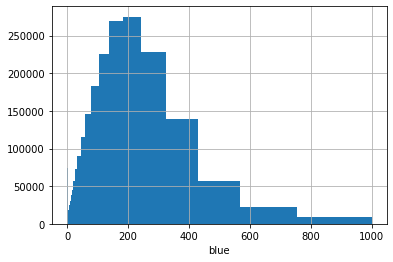

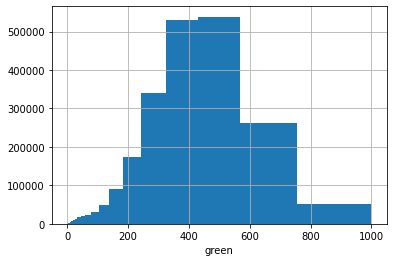

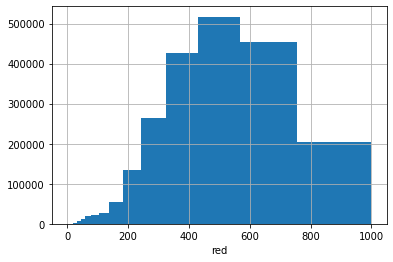

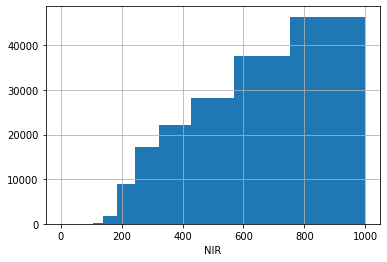

In [60]:
import numpy as np
import matplotlib.pyplot as plt
for col in ['blue','green','red','NIR']:
    gdf_processed[gdf_processed.red>0].dropna()[col].hist(bins = np.logspace(-3,3))
    plt.xlabel(col)
    plt.show()

In [62]:
precision = 5
all_expanded['x'] = all_expanded['x'].round(precision)
all_expanded['y'] = all_expanded['y'].round(precision)
gdf_processed['x'] = gdf_processed['x'].round(precision)
gdf_processed['y'] = gdf_processed['y'].round(precision)

In [79]:
merged = all_expanded.merge(gdf_processed, on=['date', 'x', 'y'])
#merge isn't working so performing a nearest spatial joing
if len(merged) == 0:
    print("Merge returned empty. Doing a spatial join based on proximity.")
    # using the smallest distance that worked
    result = gpd.sjoin_nearest(all_expanded, gdf_processed, how='inner', max_distance=0.4) 
    # filtering so all dates also match from the two gdfs
    result = result[result['date_left'] == result['date_right']]
    result = result.drop(columns = ['geometry', 'x_right', 'y_right', 'date_right', 'index_right', 'Imagery', 'date_first'])
else:
    result = merged

In [85]:
result_sorted

,geometry_x,x,y,wetdry,assumption,Imagery,date_first,date,blue,green,red,NIR,missing,NDWI,p,geometry_y
12812,POINT (563355.942 3476901.683),563355.94240,3.476902e+06,wet,assumed perennial,NaT,2016-07-22,2016-07-22,197.11,436.22,610.22,2571.78,0,-0.71,0,POINT (563355.942 3476901.683)
12813,POINT (563360.942 3476901.713),563360.94231,3.476902e+06,wet,assumed perennial,NaT,2016-07-22,2016-07-22,221.56,451.89,623.56,2511.89,0,-0.70,0,POINT (563360.942 3476901.713)
12817,POINT (563360.942 3476901.713),563360.94231,3.476902e+06,wet,assumed perennial,NaT,2016-08-28,2016-08-28,0.00,0.00,0.00,0.00,0,NaN,0,POINT (563360.942 3476901.713)
12814,POINT (563355.942 3476901.683),563355.94240,3.476902e+06,wet,assumed perennial,NaT,2016-08-28,2016-08-28,196.78,425.44,573.78,2648.78,0,-0.72,0,POINT (563355.942 3476901.683)
12815,POINT (563355.942 3476901.683),563355.94240,3.476902e+06,wet,assumed perennial,NaT,2016-08-28,2016-08-28,0.00,0.00,0.00,0.00,0,NaN,0,POINT (563355.942 3476901.683)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17695,POINT (563360.942 3476901.713),563360.94231,3.476902e+06,wet,assumed perennial,NaT,2024-03-28,2024-03-28,153.22,436.22,545.89,2042.56,0,-0.65,0,POINT (563360.942 3476901.713)
17689,POINT (563355.942 3476901.683),563355.94240,3.476902e+06,wet,assumed perennial,NaT,2024-03-28,2024-03-28,140.78,407.56,535.67,1992.00,0,-0.66,0,POINT (563355.942 3476901.683)
17688,POINT (563355.942 3476901.683),563355.94240,3.476902e+06,wet,assumed perennial,NaT,2024-03-28,2024-03-28,206.67,449.00,531.22,2133.33,0,-0.65,0,POINT (563355.942 3476901.683)
17690,POINT (563355.942 3476901.683),563355.94240,3.476902e+06,wet,assumed perennial,NaT,2024-03-28,2024-03-28,214.56,466.89,571.56,2042.11,0,-0.63,0,POINT (563355.942 3476901.683)


In [86]:
# try:
result = result.rename(columns = {'x_left':'x', 'y_left':'y', 'date_left':'date'})#.drop(columns='Imagery')
result_sorted = result.sort_values(by='date')
result_sorted = result_sorted.drop_duplicates()
# result_sorted.dropna(inplace = True)
result_sorted = result_sorted[~(result_sorted.NDWI.isna())]
result_sorted.assumption.unique()

array(['assumed perennial', 'survey/imagery match', 'assumed wet',
       'assumed dry'], dtype=object)

In [87]:
result_sorted.to_csv('../data/Ramsey/processed_assumptions/processed_with_dates_and_assumptions_drawline.csv', encoding='utf-8', index=False)

In [27]:
#in case geometry gets fixed and the file increases in size as a result 
#start = 0
#splitnum = ?
#for i in range(1,splitnum+1):
#    newstart = int(len(result_sorted)/splitnum*i)
#    result_sorted.iloc[start:newstart].to_csv('../data/Ramsey/processed_assumptions/processed_with_dates_and_assumptions'+str(i)+'.csv',index=False,
#                      float_format='%.2f')
#    start = newstart



In [39]:
result_sorted.assumption.unique()

array(['assumed perennial', 'assumed wet', 'assumed dry'], dtype=object)

<Axes: >

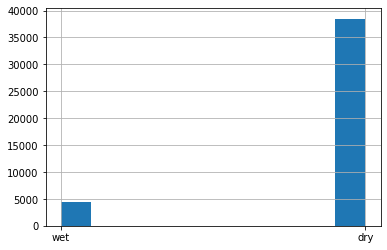

In [89]:
result_sorted.wetdry.hist()